# Repository mining
## Mine monthly LOC of VLC using cloc

### Initialize repository

In [1]:
from git import Repo
import os

# Repository URL
repo_url = "https://code.videolan.org/videolan/vlc.git"

# Clone or fetch the repository
repo_path = "vlc"  # Path where the repository will be cloned or fetched
if not os.path.exists(repo_path):
    repo = Repo.clone_from(repo_url, repo_path)
else:
    repo = Repo(repo_path)
    repo.remote().fetch()
    repo.git.checkout("master", force=True)

# Create the data stats dictionary
all_stats = {}
ui_stats = {}

### Mining functions

In [2]:
from datetime import datetime

def mine_commit(commit, year_month, update_dict):
    repo.git.checkout(commit)

    globals()[update_dict][year_month] = {}

    # Run cloc to gather the stats for each language (first line is the header, and the rest represent each language)
    cloc_output = os.popen("cloc " + os.path.join(repo_path, "modules/gui/macosx ") + os.path.join(repo_path, "modules/gui/qt") + " --csv --quiet").read() \
        if update_dict == "ui_stats" else os.popen("cloc " + repo_path + " --csv --quiet --exclude-lang='PO File','SVG','diff'").read()
    lines = cloc_output.splitlines()

    # Extract the stats from the corresponding line in cloc output
    for line in lines[2:]:
        data = line.split(",")
        language = data[1]

        # Extract the stats using the known indices (files,language,blank,comment,code) and store in stats dictionary
        globals()[update_dict][year_month][language] = {
            'files': int(data[0]),
            'blank': int(data[2]),
            'comment': int(data[3]),
            'code': int(data[4])
        }

def traverse_commits(update_dict=None):
    if update_dict is None:
        raise ValueError("update_dict must be specified")
    
    # Loop through the commits and collect relevant data for the first commit of each month
    for commit in repo.iter_commits(reverse=True):
        date = datetime.fromtimestamp(commit.committed_date)
        year_month = date.strftime("%Y-%m")

        if update_dict == "ui_stats" and date < datetime(2018, 1, 1):
            continue

        if year_month not in globals()[update_dict] or commit == last_commit: # Check if current commit is the first commit of the year/month seen
            print("Counting LOC at " + year_month + "...")
            mine_commit(commit, year_month, update_dict)

### Data pre-processing functions

In [3]:
def preprocess_data():
    #2017-11 had an error with c files
    mine_commit(repo.commit("2d06f4d7330c598464ba7cb5520753b490b181f3"), "2007-11", "all_stats")

    #combine objective c and c++ for ui_stats, into c++
    for _ , value in ui_stats.items():
        if "C++" not in value.keys():
            value["C++"] = {}
            value["C++"]['files'] = value["Objective-C"]['files']
            value["C++"]['blank'] = value["Objective-C"]['blank']
            value["C++"]['comment'] = value["Objective-C"]['comment']
            value["C++"]['code'] = value["Objective-C"]['code']
            value.pop("Objective-C")

    # Rename some languages for readability
    for dictionary in [all_stats, ui_stats]:
        # Rename Qt to QtWidgets UI
        for _ , value in dictionary.items():
            if "Qt" in value.keys():
                value["QtWidgets UI"] = value.pop("Qt")

        # Rename WiX source to WiX Toolset
        for _ , value in dictionary.items():
            if "WiX source" in value.keys():
                value["WiX Toolset"] = value.pop("WiX source")

        # Find the ratio of comment to code for each language
        for _, value in dictionary.items():
            for language in value.keys():
                value[language]['ratio'] = value[language]['comment'] / value[language]['code'] if value[language]['code'] != 0 else 0


### Mine repository or load pre-computed LOC data

In [4]:

import pickle 

load_data_from_file = True

if load_data_from_file:
    with open('data/vlc_all_stats.pkl', 'rb') as f:
        all_stats = pickle.load(f)

    with open('data/vlc_ui_stats.pkl', 'rb') as f:
        ui_stats = pickle.load(f)

    print("Data loaded")
else:
    last_commit = repo.head.commit

    print("Traversing commits monthly and analysing LOC of the entire source code from 1999...")
    traverse_commits(update_dict="all_stats")
    
    print("Traversing commits monthly and analysing LOC of only UI components (modules/gui/qt) from 2018...")
    traverse_commits(update_dict="ui_stats")

    preprocess_data()

    # Save the dictionaries
    with open('data/vlc_all_stats.pkl', 'wb') as f:
        pickle.dump(all_stats, f)

    with open('data/vlc_ui_stats.pkl', 'wb') as f:
        pickle.dump(ui_stats, f)

Data loaded


### Define plot function

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.io as pio

# Create a list of languages for each category
programming_languages = ['C', 'C/C++ Header', 'C++', 'Objective-C', 'QML', 'JavaScript', 'Lua', 'Python', 'Java', 'Assembly', 'Delphi Form', 'C#', 'Visual Basic', 'Perl', 'R', 'IDL']
markup_languages = ['XML', 'QML', 'HTML', 'Markdown', 'CSS', 'QtWidgets UI', 'YAML', 'DTD', 'JSON', 'XSD']
build_tools = ['make', 'm4', 'Meson', 'CMake', 'WiX Toolset', 'Maven']
languages_of_gui_folder = ['C++', 'Objective-C', 'QML', 'QtWidgets UI', 'XML']

# Define color for every language
language_colors = {'C': '#2E91E5', 'C/C++ Header': '#E15F99', 'C++': '#1CA71C', 'Objective-C': '#FB0D0D', 'QML': '#DA16FF', 'JavaScript': '#222A2A', 'Python': '#B68100', 
                   'Visual Basic': '#750D86', 'C#': '#EB663B', 'Java': '#511CFB','R': '#00A08B', 'Perl': '#F2CB61', 'Assembly': '#F9BA00', 'IDL': '#A777F1', 'Lua': '#FBCA03', 'Delphi Form': '#2E91E5',
                   'YAML': '#7B0323', 'XML': '#5FA8E3', 'HTML': '#41C041', 'Markdown': '#B2828D', 'CSS': '#6C7C32', 'QtWidgets UI': '#778AAE', 'XSD': '#862A16', 'JSON': '#E15F99', 'DTD': '#1CA71C',
                   'make': '#620042', 'm4': '#1616A7', 'Meson': '#DA60CA', 'WiX Toolset': '#6C4516', 'CMake': '#0D2A63', 'Maven': '#AF0038', 'SUM': '#000000'}

export_figures_as_html = False
export_figures_as_png = True

def plot_languages(data, languages, fileName):
    keys = ["files", "code", "comment", "ratio"]
    subplot_titles = ["Number of Files", "Lines of Code", "Lines of Comments", "Comments to Code ratio"]
    fig = make_subplots(rows=1, cols=len(keys), subplot_titles=subplot_titles)
    colors = [language_colors[language] for language in languages]

    # Keep a global sum of the data for each key
    sum = [[], [], [], []]
    
    for j in range(len(keys)):
        key = keys[j]       
        
        for i, language in enumerate(languages):
            # Get the value of the key for each month
            num = [data[monthYear].get(language, {key: 0 if key!="ratio" else None})[key] for monthYear in data.keys()]
            
            # Add the value to the global sum
            if key != "ratio":
                sum[j] = num if len(sum[j]) == 0 else np.add(sum[j], [0 if x is None else x for x in num])
            else:
                # In case of ratio, if a language has always no comments, exlude the code from the sum for more correct comment to code ratio
                backupKey = "comment"
                comments_num = [data[monthYear].get(language, {backupKey: 0})[backupKey] for monthYear in data.keys()]
                if all(x == 0 for x in comments_num):
                    backupKey = "code"
                    code_num = [data[monthYear].get(language, {backupKey: 0})[backupKey] for monthYear in data.keys()]
                    sum[1] = np.subtract(sum[1], code_num)

            # Don't add trace if all values are 0 (makes 'comments' plots better, since some files are autogenerated and have no comments)
            if all(x == 0 or x == None for x in num):
                continue

            # Add trace to the plot
            fig.add_trace(go.Scatter(x=list(data.keys()), y=num, mode='lines', name=language, legendgroup=language, 
                                     showlegend=j==0, line=dict(color=colors[i % len(colors)])), row=1, col=j+1)
            # In case language has very few lines of code, make the trace visible only in the legend
            if language in ['C#', 'Visual Basic', 'Perl', 'R', 'YAML', 'XSD', 'IDL', 'Delphi Form', 'JSON', 'DTD', 'Assembly']:
                fig.data[-1].visible = "legendonly"
            
        # Add a total number trace for every plot
        if languages!=["SUM"]: # Don't add total if plot is only for cloc's SUM
            if key=="ratio": # Ratio needs to be calculated separately
                sum[j] = [0 if sum[1][i] == 0 else sum[2][i]/sum[1][i] for i in range(len(sum[1]))]

            fig.add_trace(go.Scatter(x=list(data.keys()), y=sum[j], mode='lines', name="Total", legendgroup="Total", legendrank=1,
                                    showlegend=j==0, line=dict(color="#000000")), row=1, col=j+1)
            fig.data[-1].visible = "legendonly" # Hide the total trace by default

    # Add vertical lines for VLC major releases
    dashed_line = dict(color="black", dash='dash', width=1)
    vlc0 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2001-02', x1='2001-02', y0=0, y1=1,
                      line=dashed_line) for j in range(len(keys))]
    vlc1 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2009-07', x1='2009-07', y0=0, y1=1,
                      line=dashed_line) for j in range(len(keys))]
    vlc2 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2012-02', x1='2012-02', y0=0, y1=1,
                      line=dashed_line) for j in range(len(keys))]
    vlc3 = [dict(type="line", xref="x"+str(j+1), yref='paper', x0='2018-02', x1='2018-02', y0=0, y1=1,
                      line=dashed_line) for j in range(len(keys))]
   
    if export_figures_as_html or not export_figures_as_png:
        # Add buttons to show/hide major release date lines
        fig.update_layout(updatemenus=[dict(buttons=list([dict(args=["shapes", []], label="Hide major releases date lines", method="relayout"), 
            dict(args=["shapes", vlc0 + vlc1+ vlc2 + vlc3 if '2017-12' in data.keys() else vlc3], label="Show major releases date lines", method="relayout")]),
            type="buttons", direction="right", showactive=True, x=0.5, xanchor="center", y=-0.45, yanchor="top")])
    
    fig.update_layout(legend=dict(orientation="h", xanchor="center", yanchor="bottom", x=0.5, y=1.1),
                      margin=dict(l=20, r=20, t=40, b=100))

    vlc_releases = {'2000-06': '0.1.99a', '2003-02': '0.5', '2004-11': '0.8', '2006-05': '0.8.5',
                    '2009-07': '1.0', 
                    '2012-02': '2.0', '2013-07': '2.1', '2015-02': '2.2',
                    '2018-02': '3.0', '2020-04': '3.0.10', '2023-11': '3.0.20'}
    
    # Show 3.0 minor releases for ui plot
    if '2017-12' not in data.keys():
        vlc_releases = {'2018-02': '3.0', '2018-08': '3.0.4', '2019-01': '3.0.6', '2019-07': '3.0.7',
                        '2020-04': '3.0.10', '2021-01': '3.0.12', '2021-06': '3.0.16', '2022-04': '3.0.17', 
                        '2022-11': '3.0.18', '2023-11': '3.0.20'}
    
    # Add release dates to x axis
    version_keys = list(vlc_releases.keys())
    version_values = list(vlc_releases.values())  
    for i in range(1, len(keys)+1):
        fig.update_xaxes(automargin=True, tickangle=45, tickfont=dict(size=11), tickvals = version_keys, 
                         ticktext = ["  " + version_keys[i] + " (" + version_values[i] + ")" for i in range(len(version_keys))], row=1, col=i)

    if export_figures_as_html:
        # Save plots as html
        if not os.path.exists('plots'):
            os.makedirs('plots')
        pio.write_html(fig, file='plots/vlc_'+fileName+'.html')

    if export_figures_as_png:
        fig.update_layout(autosize=False, width=1600, height=350) 
        
        if not os.path.exists('figures'):
            os.makedirs('figures')
        fig.write_image("figures/vlc_"+fileName+".png")

        #Include major releases vertical lines
        for k in range(len(keys)):
            if '2017-12' in data.keys():
                fig.add_shape(vlc0[k])
                fig.add_shape(vlc1[k])
                fig.add_shape(vlc2[k])
            fig.add_shape(vlc3[k])
        
        if not os.path.exists('figures/with_major_releases_lines'):
            os.makedirs('figures/with_major_releases_lines')
        fig.write_image("figures/with_major_releases_lines/vlc_"+fileName+".png")
        
        # Show plots as png (to be visible on github)
        fig.show("png")
    else:
        fig.show()
    

### Plot

All files


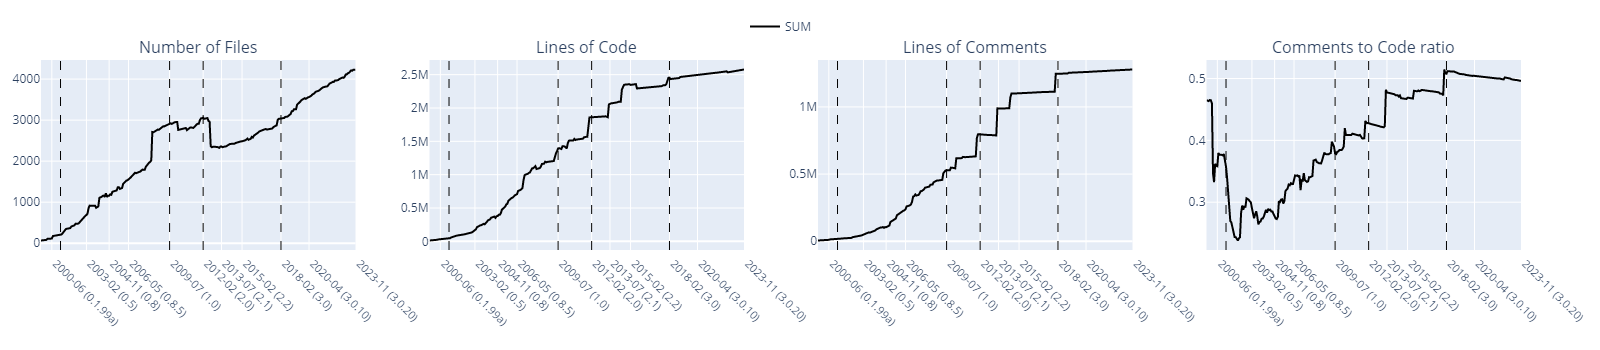

Programming languages


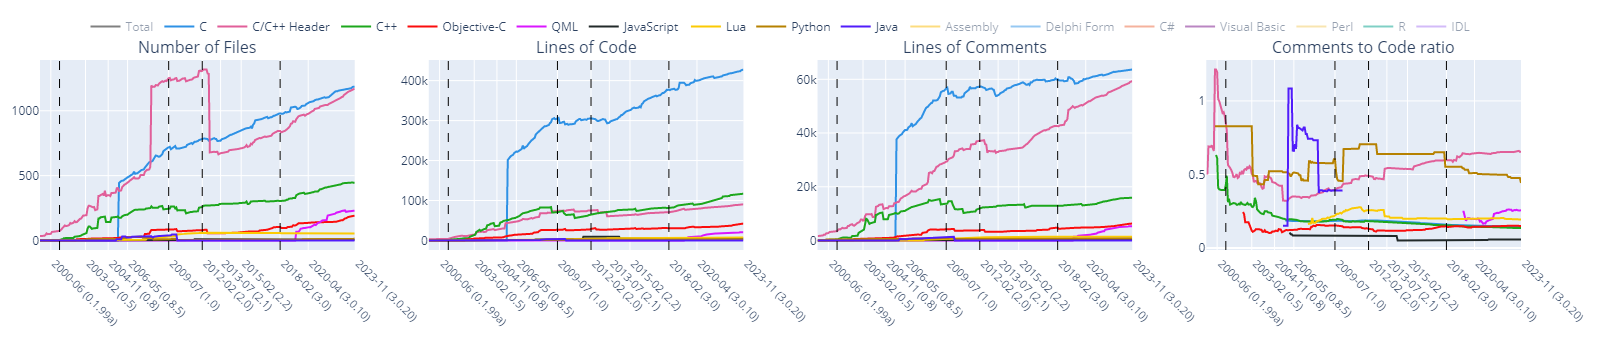

Markup languages


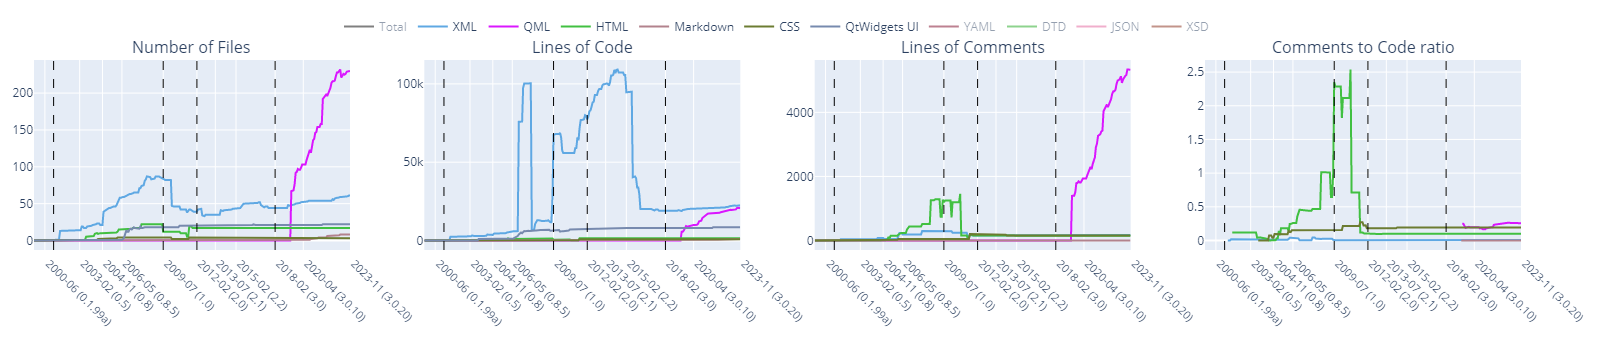

Build tools


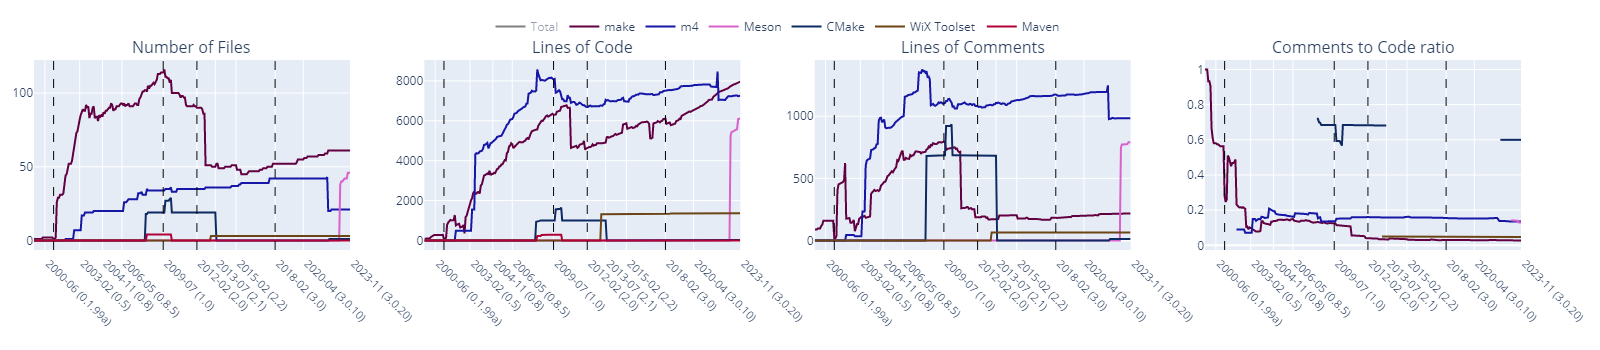

UI languages related to UI components from 2018


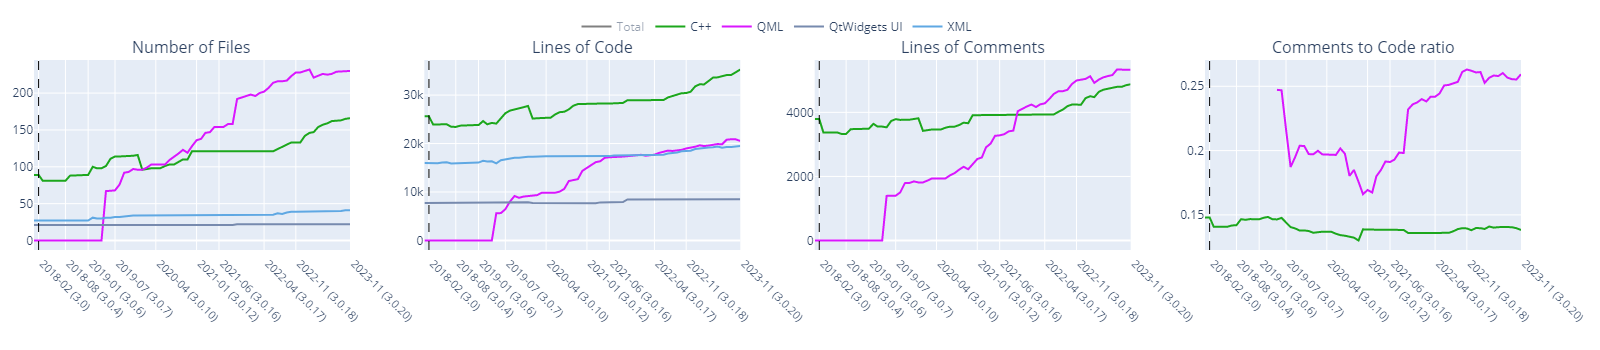

In [13]:
# Create plots of interest
print("All files")
plot_languages(all_stats, ['SUM'], "all_files")

print("Programming languages")
plot_languages(all_stats, programming_languages, "programming_languages")

print("Markup languages")
plot_languages(all_stats, markup_languages, "markup_languages")

print("Build tools")
plot_languages(all_stats, build_tools, "build_tools")

print("UI languages related to UI components from 2018")
plot_languages(ui_stats, languages_of_gui_folder, "ui_languages")